<a href="https://colab.research.google.com/github/dqniellew1/DLPT/blob/master/Using_a_neural_network_to_fit_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
drive_dir = 'drive/My Drive/dlwpt-code/data/'

In [2]:
import torch

Basic building block of the complicated functions that make up a neural networks are `neurons`. It consists of a linear transformation of the input and the application of a fixed non-linear function.

Mathematically: `o = f(w * x + b)`
- o for output
- f for activation function
- w for weights (can be a single scalar of matrix)
- x for inputs (is a scalar or vector)
- b for bias / offset

**\*the dimensionality of the inputs and weights must match**

Generalities about activation functions
- are non-linear. The non-linearity allows the overall network to approximate more complex functions.
- are differentiable, so that gradients can be computed through them, *with exceptions

Without those, the network falls back to being a complicated polynomial or becomes difficult to train.

*Code from chapter 5

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # temperatures in Celsius
t_u = torch.tensor(t_u).unsqueeze(1) # Unknown units

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

In [5]:
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  8,  2,  0,  7,  9,  5,  6,  3]), tensor([1, 4]))

In [6]:
# Build training and validation set 
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

# scale our data
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [7]:
import torch.nn as nn

In [8]:
# nn.Linear is a subclass of nn.Module
# Linear have their own `__call__` method, therefore we can call it like a function
linear_model = nn.Linear(1, 1)
linear_model(val_t_un)

tensor([[-2.7810],
        [-2.8040]], grad_fn=<AddmmBackward>)

`y = model(x)` do this

`y = model.forward(x)` dont do this

The constructor to `nn.Linear` accepts three arguments:
1. the number of input features
2. the number of output features
3. Whether the linear model includes a bias or not (defaults to true)

\* The number of features in our case refers to the size of the input and the output tensor for the module.

If we used both temperature and barometric pressure in input, for instance, we would have two features in input and one feature in output.

Above we have an instance of `nn.Linear` with one input and one output feature. That only requires one weight and one bias.

In [9]:
linear_model.weight

Parameter containing:
tensor([[-0.5741]], requires_grad=True)

In [10]:
linear_model.bias

Parameter containing:
tensor([0.4283], requires_grad=True)

We can call the module with some inputs

In [11]:
x = torch.ones(1)
linear_model(x)

tensor([-0.1458], grad_fn=<AddBackward0>)

Although PyTorch let us get away with it, we didn't actually provide an input with the right dimensionality. We have a model that takes one input and produces one output, but PyTorch `nn.Module` and its subclasses are designed to do so on multiple samples at the same time. To accomodate multiple samples, modules expect the **zeroth dimension of the input to be the number of samples in the batch**.

Any module in `nn` is writtern to produce outputs for a batch of multiple inputs at the same time. Thus, assuming we need to run `nn.Linear` on 10 samples, we can create an input tensor of size `B x N_inputs`, where `B` is the size of the batch and `N_inputs` the number of input features, and run it once through the model.

In [12]:
x = torch.ones(10, 1) # 10 batches, of 1 input
linear_model(x)

tensor([[-0.1458],
        [-0.1458],
        [-0.1458],
        [-0.1458],
        [-0.1458],
        [-0.1458],
        [-0.1458],
        [-0.1458],
        [-0.1458],
        [-0.1458]], grad_fn=<AddmmBackward>)

In [13]:
import torch.optim as optim

Let's update our training code.


In [14]:
# 1. replace our handmade model with nn.Linear(1,1)
linear_model = nn.Linear(1, 1)
# 2. pass the linear model parameters to the optimizer
optimizer = optim.SGD(
    linear_model.parameters(), # all the `w` and `b`'s of the model
    lr = 1e-2)

Earlier it was our responsibility to create parameters and pass them as first argument to `optim.SGD`. Now we can just ask any `nn.Module` for a list of parameters owned by it. or any of its submodules using the `paramters` method.

In [15]:
linear_model.parameters()

<generator object Module.parameters at 0x7f08a6caeca8>

In [16]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.8144]], requires_grad=True), Parameter containing:
 tensor([-0.1281], requires_grad=True)]

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
  for epoch in range(1, n_epochs + 1):
    t_p_train = model(t_u_train)
    loss_train = loss_fn(t_p_train , t_c_train)

    t_p_val = model(t_u_val)
    loss_val = loss_fn(t_p_val, t_c_val)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print('Epoch {}, Training loss {}, Validation loss {}'.format(
          epoch, float(loss_train), float(loss_val)))

The training loop does not change at all from our hand made example, **except that now we don't pass `params` explicitly to `model`** since the model itself holds its `Parameters` internally.

We can leverage loss functions from `torch.nn`. `nn` comes with several common loss functions amoong which `nn.MSELoss` which is exactly what we defined earlier as our `loss_fn`. Loss functions in `nn` are still subclasses of `nn.Module`, so we will create an instance and call it as a function. In our case, we got rid of the hand-written `loss_fn` and replace it.

In [18]:
linear_model = nn.Linear(1, 1) # applies an affine transformation to its input via model parameters
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # create an instance and call it as a function
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 269.68682861328125, Validation loss 234.68382263183594
Epoch 1000, Training loss 3.547642230987549, Validation loss 2.726200580596924
Epoch 2000, Training loss 2.986647605895996, Validation loss 2.731076955795288
Epoch 3000, Training loss 2.977858304977417, Validation loss 2.731765031814575

Parameter containing:
tensor([[5.3753]], requires_grad=True)
Parameter containing:
tensor([-17.2710], requires_grad=True)


A neural network

In [19]:
seq_model = nn.Sequential(
    nn.Linear(1, 13), 
    nn.Tanh(),
    nn.Linear(13, 1))

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

**13 was chosen arbitrarily.** We wanted to pick a number that was a different size from the other various tensor shapes we have floating around.

Calling `model.parameters()` will collect `weight` and `bias` from both the first and second linear modules. It's instructive to inspect the parameters in this case by printing their shapes.

In [20]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

Notes on parameters of `nn.Modules`:

When inspecting parameters of a model made up of several submodules, it is handy to be able to identify parameters by their name. We can use a method called `named_parameters`.

In [21]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Each module in `Sequential` is just the ordinal with which the module has appeared in the arguments.

`Sequential` also accepts an `OrderedDict`, where we can name each module passed to `Sequential`

In [22]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
  ('hidden_linear', nn.Linear(1, 8)),
  ('hidden_activation', nn.Tanh()),
  ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

This allows us to get more explanatory names for submodules.

In [23]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


Getting a particular `Parameter` by accessing submodules as if they were attributes.

In [24]:
# access submodules with named parameters
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2402], requires_grad=True)

This is useful for inspecting parameters or their gradients, for instance to monitor gradients during training. Say we want to print out the gradients of `weight` of the linear portion of the hidden layer. We can run the training loop for the new neural network, then look at the resulting gradients after the last epoch.

In [25]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c)

print()
print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 211.77630615234375, Validation loss 181.38186645507812
Epoch 1000, Training loss 5.706830024719238, Validation loss 3.1043033599853516
Epoch 2000, Training loss 3.871067523956299, Validation loss 5.265519618988037
Epoch 3000, Training loss 2.4359922409057617, Validation loss 3.1837515830993652
Epoch 4000, Training loss 1.7194355726242065, Validation loss 2.704766035079956
Epoch 5000, Training loss 1.5804448127746582, Validation loss 2.8087449073791504

output tensor([[11.2616],
        [11.5299]], grad_fn=<AddmmBackward>)
answer tensor([[14.],
        [11.]])
hidden tensor([[-0.2851],
        [ 0.1043],
        [ 9.3268],
        [ 8.7398],
        [-0.3371],
        [-9.1195],
        [ 0.0220],
        [ 9.8607]])


We can also evaluate the model on the whole data and see how different that is from a line.

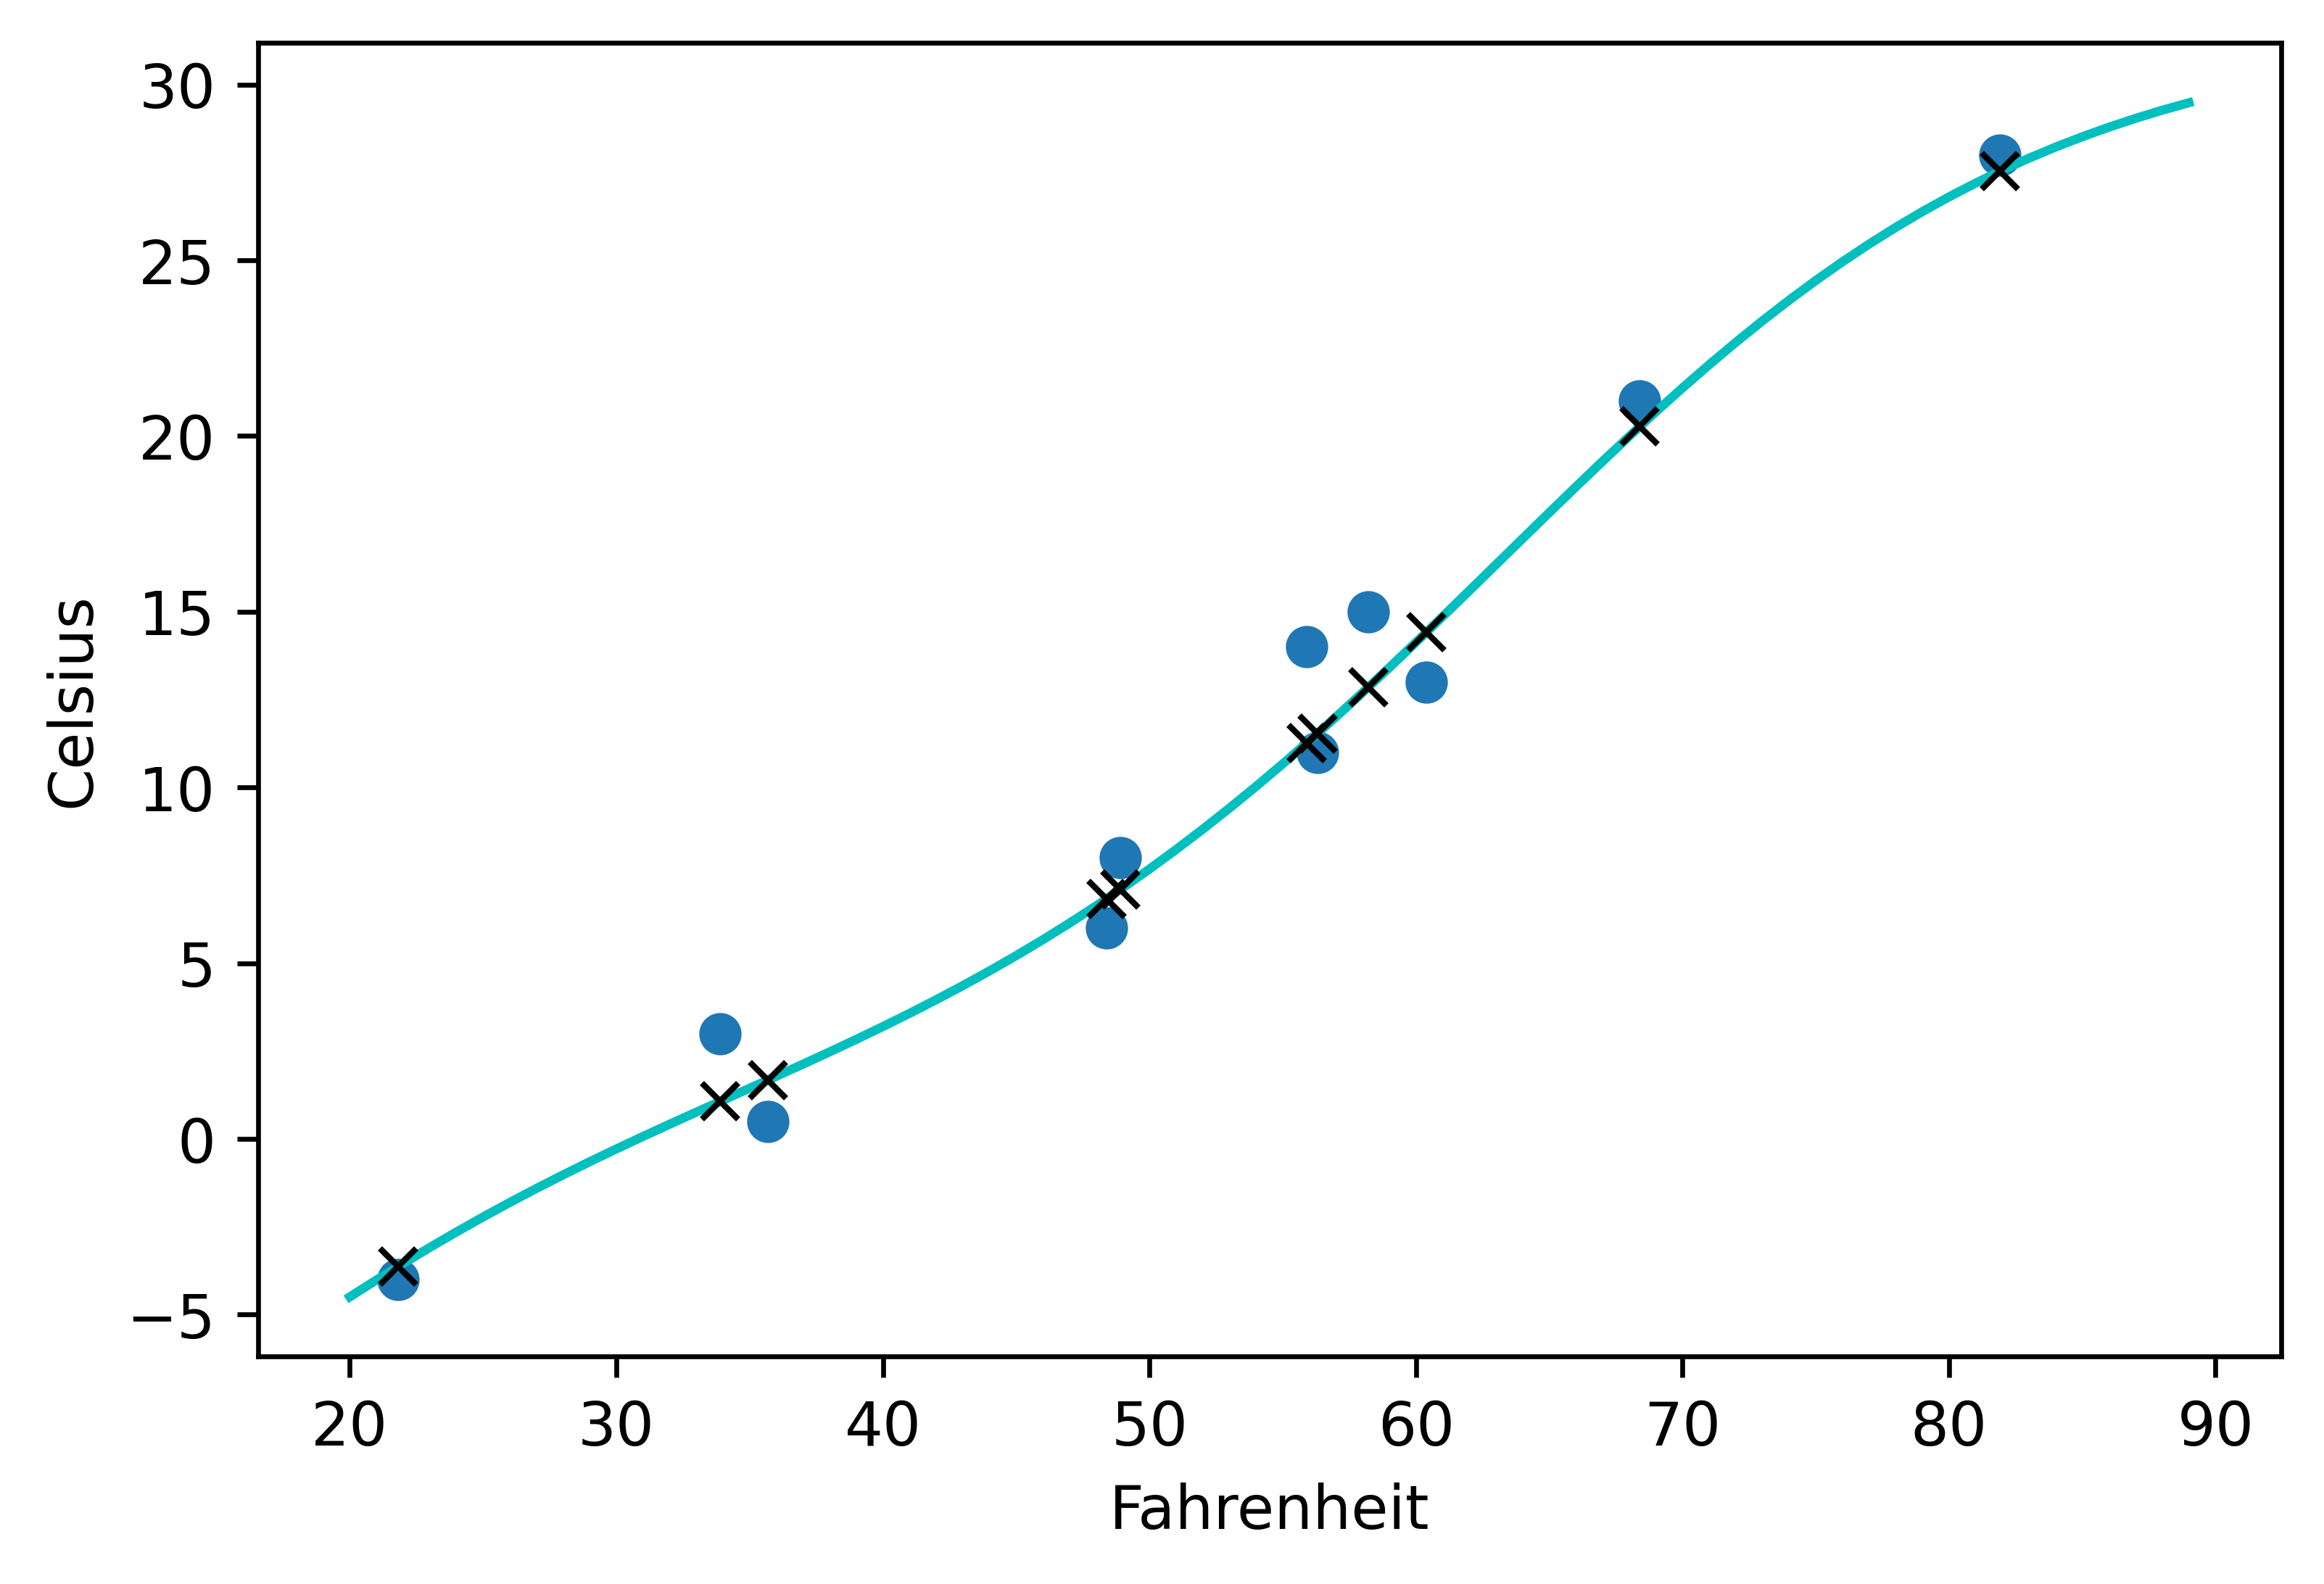

In [26]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx');

## Subclassing nn.Module

For larger and more complex projectsm we need to leave `nn.Sequential` behind in favor of something that gives us more flexibility: subclassing `nn.Module`. In order to subclass `nn.Module`, **at a minimum we need to define a `.forward(...)` function** that takes the input to the module and returns the output. If we use standard `torch` operations, `autograd` will take care of the backward pass automatically.

**3 different ways to implement the same network structure**

using increasingly more complex PyTorch functionality to do so. As we do so, we will vary the number of neurons in the hidden layer to make it easier to differentiate between approaches. The first will be a simple instance of `nn.Sequential` like we've already seen.

In [27]:
# 1 
seq_model = nn.Sequential(
    nn.Linear(1, 11),
    nn.Tanh(),
    nn.Linear(11, 1))

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=11, bias=True)
  (1): Tanh()
  (2): Linear(in_features=11, out_features=1, bias=True)
)

While this works, we dont have any semantic information about what the various layers are intended to be. We can rectify that by giving each layer a label, using an ordered dictionary instead of a list as input.

In [28]:
# 2
namedseq_model = nn.Sequential(OrderedDict(
    [('hidden_linear', nn.Linear(1, 12)),
     ('hidden_activation', nn.Tanh()),
     ('output_linear', nn.Linear(12, 1))
]))

namedseq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=12, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=12, out_features=1, bias=True)
)

Much better. We don't have any ability to control the flow of data through the network, however, aside from the purely sequential pass-through provided by `nn.Sequential`. We can take **full control** of the processing of input data by subclassing `nn.Module` ourselves:

In [29]:
# 3
class SubClassModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.hidden_linear = nn.Linear(1, 13)
    self.hidden_activation = nn.Tanh()
    self.output_linear = nn.Linear(13, 1)

  def forward(self, input):
    hidden_t = self.hidden_linear(input)
    activated_t = self.hidden_activation(hidden_t)
    output_t = self.output_linear(activated_t)

    return output_t

subclass_model = SubClassModel()
subclass_model

SubClassModel(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

This method ends up being somewhat more verbose, since we have to both 

1.   define the layers we wish to have
2.   and to then define how and in what order they should be applied in the `forward` function.


That **repetition** grants us an incredible amount of flexibility over the sequential models, however as we are now free to do all sorts of interesting things inside the `forward` function.

While this example is unlikely to make sense, we could implement:
```
activated_t = self.hidden_activation(hidden_t) if random.random() > 0.5 else hidden_t
```
to only apply the activation function half of the time!



In [30]:
# Internals of all 3 models
for type_str, model in [('seq', seq_model), ('namedseq', namedseq_model), ('subclass', subclass_model)]:
  print(type_str)
  for name_str, param in model.named_parameters():
    print("{:21} {:19} {}".format(name_str, str(param.shape), param.numel()))
  
  print()

seq
0.weight              torch.Size([11, 1]) 11
0.bias                torch.Size([11])    11
2.weight              torch.Size([1, 11]) 11
2.bias                torch.Size([1])     1

namedseq
hidden_linear.weight  torch.Size([12, 1]) 12
hidden_linear.bias    torch.Size([12])    12
output_linear.weight  torch.Size([1, 12]) 12
output_linear.bias    torch.Size([1])     1

subclass
hidden_linear.weight  torch.Size([13, 1]) 13
hidden_linear.bias    torch.Size([13])    13
output_linear.weight  torch.Size([1, 13]) 13
output_linear.bias    torch.Size([1])     1



## Functional api

PyTorch has functional counterparts of every `nn` module. They have no **internal states**, which means their output value is solely determined by the value input arguments.

how `nn.functional.linear` differs from `nn.Linear` is the former is a function `linear(input, weight, bias=None)` which `weight` and `bias` are arguments to the function.

In [73]:
# Subclass Functional model
class SubclassFunctionalModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.hidden_linear = nn.Linear(1, 5000)
    # self.hidden_activation missing here
    self.output_linear = nn.Linear(5000, 1)

  def forward(self, input):
    hidden_t = self.hidden_linear(input)
    activated_t = torch.tanh(hidden_t) # replaced with functional equivalent here
    output_t = self.output_linear(activated_t)

    return output_t

func_model = SubclassFunctionalModel()
func_model

SubclassFunctionalModel(
  (hidden_linear): Linear(in_features=1, out_features=5000, bias=True)
  (output_linear): Linear(in_features=5000, out_features=1, bias=True)
)

In [74]:
optimizer = optim.SGD(func_model.parameters(), lr=1e-5)

In [43]:
training_loop(n_epochs=5000,
              optimizer=optimizer,
              model=func_model,
              loss_fn=nn.MSELoss(),
              t_u_train = train_t_un,
              t_u_val = val_t_un,
              t_c_train = train_t_c,
              t_c_val = val_t_c)

print()
print('output', func_model(val_t_un))
print('answer', val_t_c)
print('hidden', func_model.hidden_linear.weight.grad)

Epoch 1, Training loss 193.69998168945312, Validation loss 158.41061401367188
Epoch 1000, Training loss 3.5232410430908203, Validation loss 4.649674415588379
Epoch 2000, Training loss 1.681070327758789, Validation loss 3.0580990314483643
Epoch 3000, Training loss 1.507872462272644, Validation loss 3.0019781589508057
Epoch 4000, Training loss 1.4051522016525269, Validation loss 2.980046272277832
Epoch 5000, Training loss 1.331236481666565, Validation loss 2.974571943283081

output tensor([[12.2929],
        [12.4906]], grad_fn=<AddmmBackward>)
answer tensor([[14.],
        [11.]])
hidden tensor([[ 1.0130e-01],
        [ 1.0006e-01],
        [ 9.2111e-02],
        [ 6.9672e-04],
        [ 5.9814e+00],
        [-1.0063e-01],
        [ 5.0829e+00],
        [ 1.4717e+00],
        [ 2.2791e-03],
        [ 2.9921e+00],
        [-6.1711e+00],
        [ 6.6498e-02],
        [ 2.0167e-02]])


# Exercise

In [44]:
import csv
import numpy as np

In [45]:
wine_path = drive_dir + 'p1ch4/tabular-wine/winequality-white.csv'
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=';', skiprows = 1)

In [49]:
wineq = torch.from_numpy(wineq_numpy)
wineq.shape

torch.Size([4898, 12])

In [51]:
data = wineq[:, :-1]
data.shape

torch.Size([4898, 11])

In [64]:
target = wineq[:, -1].long()

In [70]:
target.shape

torch.Size([4898])

In [65]:
target.unique()
# 7 values in targets

tensor([3, 4, 5, 6, 7, 8, 9])

In [66]:
target_onehot = torch.zeros(target.shape[0], 10)

In [67]:
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [72]:
target_unsqueezed = target.unsqueeze(1)
target_unsqueezed

tensor([[6],
        [6],
        [6],
        ...,
        [6],
        [7],
        [6]])

In [75]:
# Wine model
# Create train/val split
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

wine_train = data[train_indices]
wine_val = data[val_indices]

wine_train_un = 0.1 * wine_train
wine_val_un = 0.1 * wine_val

In [76]:
class WineModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.hidden_linear = nn.Linear(11, 5000)
    self.output_linear = nn.Linear(5000, 11)

  def forward(self, input):
    hidden_t = self.hidden_linear(input)
    activated_t = torch.tanh(hidden_t)
    output_t = self.output_linear(activated_t)

    return output_t

winemodel = WineModel()
winemodel

WineModel(
  (hidden_linear): Linear(in_features=11, out_features=5000, bias=True)
  (output_linear): Linear(in_features=5000, out_features=11, bias=True)
)

In [77]:
optimizer = optim.SGD(winemodel.parameters(), lr=1e-2)

In [78]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_c_train):
  for epochs in range(1, n_epochs + 1):
    t_p_train = model(t_u_train)
    loss_train = loss_fn(t_p_train, t_c_train)

    optimizer.zero_grad()
    loss_train.forward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print('Epoch {}, Training loss {}'.format(epoch, float(loss_train)))

In [79]:
winemodel(wine_train_un)

tensor([[ 0.3241,  0.6139, -0.2784,  ...,  0.5091, -0.3509, -0.2297],
        [ 0.5696,  0.7081, -0.4732,  ...,  0.4179, -0.4318, -0.3117],
        [ 0.4712,  0.7055, -0.3483,  ...,  0.4396, -0.4711, -0.2456],
        ...,
        [ 0.2600,  0.6222, -0.2532,  ...,  0.5632, -0.3162, -0.1990],
        [ 0.3317,  0.6666, -0.2257,  ...,  0.4637, -0.4532, -0.1500],
        [ 0.1799,  0.6026, -0.1531,  ...,  0.5865, -0.3052, -0.1513]],
       grad_fn=<AddmmBackward>)

In [81]:
wine_train_un

tensor([[0.7600, 0.0360, 0.0440,  ..., 0.3120, 0.0430, 1.0200],
        [0.6700, 0.0280, 0.0140,  ..., 0.3170, 0.0390, 1.0000],
        [0.6600, 0.0260, 0.0460,  ..., 0.3200, 0.0450, 0.9300],
        ...,
        [0.7400, 0.0340, 0.0420,  ..., 0.3120, 0.0530, 1.1300],
        [0.7400, 0.0190, 0.0300,  ..., 0.3140, 0.0490, 0.9100],
        [0.7100, 0.0310, 0.0500,  ..., 0.2940, 0.0440, 0.9100]])